In [379]:
# import libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt


# Inline plots for Jupyter Notebooks
%matplotlib inline

In [381]:
def get_historical_data(coin_id, vs_currency, days):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart'
    params = {'vs_currency': vs_currency, 'days': days}
    
    print(f"Requesting data for: {coin_id}, Currency: {vs_currency}, Days: {days}")
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        return df
    else:
        print(f"Error fetching data: {response.status_code}")
        print(response.json())  # Print the error response for more detail
        return None

In [383]:
# TEST Fetch : Fetch 180 days of Bitcoin data
data = get_historical_data('bitcoin', 'usd', 180)

if data is not None:
    print(data.head())

Requesting data for: bitcoin, Currency: usd, Days: 180
   timestamp         price
0 2024-06-16  66190.487489
1 2024-06-17  66615.537821
2 2024-06-18  66460.388979
3 2024-06-19  65109.314812
4 2024-06-20  64907.074608


In [385]:
# Check the length of your data
print(len(data))  # Length of your data in rows (days)
print(data['timestamp'].min(), data['timestamp'].max())  # Check the date range


181
2024-06-16 00:00:00 2024-12-12 00:40:17


## Define Indicators

#### RSI

In [389]:
# Define the RSI
def rsi(data, window=14):
    delta = data['price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [391]:
# Apply RSI 
data['rsi'] = rsi(data)

#### 50 Period Moving Average

In [394]:
def moving_average(data, window=50):
    return data['price'].rolling(window=window).mean()

In [396]:
# Apply 50-period MA 
data['50_ma'] = moving_average(data)

#### MACD 

In [399]:
def macd(data, fast_period=12, slow_period=26, signal_period=9):
    # Calculate the EMAs
    fast_ema = data['price'].ewm(span=fast_period, min_periods=fast_period).mean()
    slow_ema = data['price'].ewm(span=slow_period, min_periods=slow_period).mean()
    
    # Calculate MACD
    macd = fast_ema - slow_ema
    signal = macd.ewm(span=signal_period, min_periods=signal_period).mean()

    return macd, signal

In [401]:
# Apply MACD and Signal to your data
data['macd'], data['macd_signal'] = macd(data)

### Check indicators : Handle NaNs that result

##### Test 50 SMA

    timestamp         price         50_ma
0  2024-06-16  66190.487489           NaN
1  2024-06-17  66615.537821           NaN
2  2024-06-18  66460.388979           NaN
3  2024-06-19  65109.314812           NaN
4  2024-06-20  64907.074608           NaN
5  2024-06-21  64844.674418           NaN
6  2024-06-22  64071.624285           NaN
7  2024-06-23  64239.903488           NaN
8  2024-06-24  63221.357384           NaN
9  2024-06-25  60363.234975           NaN
10 2024-06-26  61770.413870           NaN
11 2024-06-27  60749.896194           NaN
12 2024-06-28  61562.645326           NaN
13 2024-06-29  60317.096979           NaN
14 2024-06-30  60864.443162           NaN
15 2024-07-01  62734.393839           NaN
16 2024-07-02  62819.822269           NaN
17 2024-07-03  62042.565037           NaN
18 2024-07-04  60244.680764           NaN
19 2024-07-05  57189.174124           NaN
20 2024-07-06  56739.862851           NaN
21 2024-07-07  58230.484154           NaN
22 2024-07-08  55880.375378       

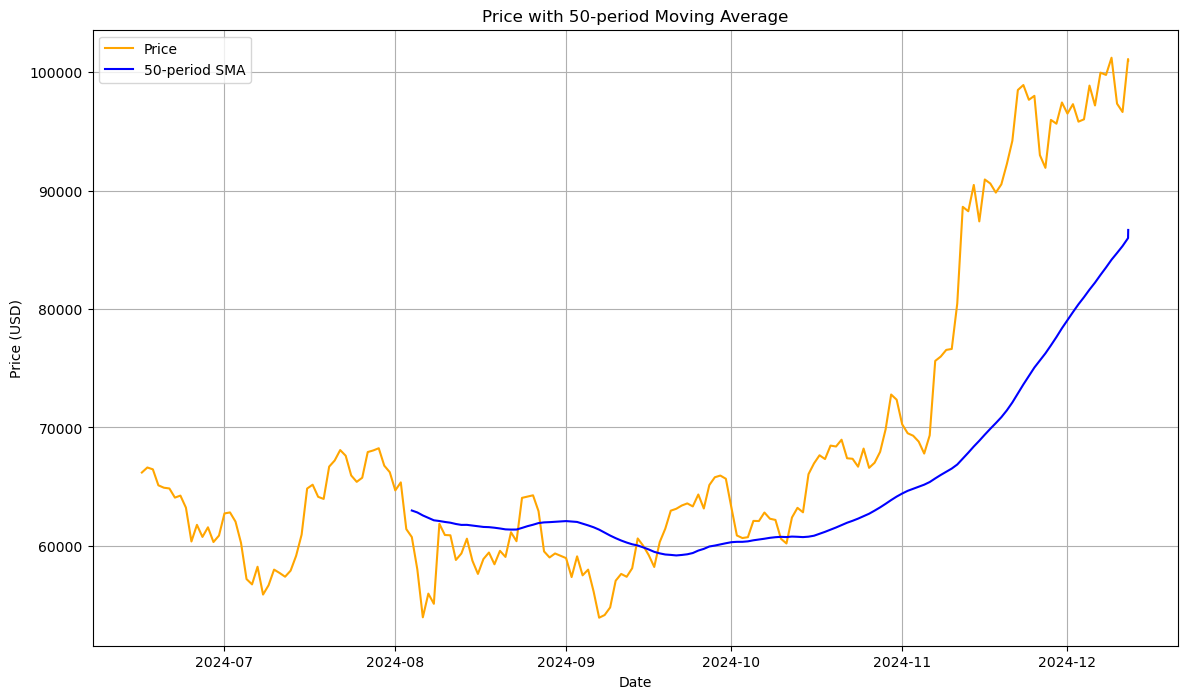

In [405]:
# Check the first few rows to make sure the 50-period moving average is calculated correctly
print(data[['timestamp', 'price', '50_ma']].head(60))  # Check the first 60 rows to see the MA in action

# Plot the price and 50-period moving average
plt.figure(figsize=(14, 8))
plt.plot(data['timestamp'], data['price'], label='Price', color='orange')
plt.plot(data['timestamp'], data['50_ma'], label='50-period SMA', color='blue')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Price with 50-period Moving Average')
plt.legend()
plt.grid(True)
plt.show()

In [407]:
# Drop rows where the '50_ma' column has NaN values
data_clean = data.dropna(subset=['50_ma'])

# Check the cleaned data
print(data_clean.head(60))  # Display the first 60 rows after cleaning
print(f"Number of rows in cleaned data: {len(data_clean)}")  # Check how many rows are left


     timestamp         price        rsi         50_ma         macd  \
49  2024-08-04  60738.744925  28.815672  62981.625838   301.446676   
50  2024-08-05  58006.206587  20.546258  62817.940220  -232.712008   
51  2024-08-06  53956.261842  17.000575  62564.754700  -966.030888   
52  2024-08-07  55959.841074  26.257582  62354.743742 -1372.070768   
53  2024-08-08  55099.951811  25.862670  62154.556482 -1742.045633   
54  2024-08-09  61859.031599  42.990908  62093.595622 -1480.036878   
55  2024-08-10  60912.588533  36.794071  62014.953904 -1332.455126   
56  2024-08-11  60887.708616  36.436216  61951.275591 -1203.597169   
57  2024-08-12  58804.234500  33.336155  61842.562211 -1253.340590   
58  2024-08-13  59350.074333  36.455818  61765.136550 -1234.890654   
59  2024-08-14  60601.223178  40.001241  61769.896314 -1107.453036   
60  2024-08-15  58739.193822  39.546886  61709.271913 -1142.258875   
61  2024-08-16  57624.116929  36.598463  61646.756328 -1244.743858   
62  2024-08-17  5888

In [409]:
# Check the first few rows to make sure the 50-period moving average is calculated correctly
print(data_clean[['timestamp', 'price', '50_ma']].head(60))  # Check the first 60 rows to see the MA in action

     timestamp         price         50_ma
49  2024-08-04  60738.744925  62981.625838
50  2024-08-05  58006.206587  62817.940220
51  2024-08-06  53956.261842  62564.754700
52  2024-08-07  55959.841074  62354.743742
53  2024-08-08  55099.951811  62154.556482
54  2024-08-09  61859.031599  62093.595622
55  2024-08-10  60912.588533  62014.953904
56  2024-08-11  60887.708616  61951.275591
57  2024-08-12  58804.234500  61842.562211
58  2024-08-13  59350.074333  61765.136550
59  2024-08-14  60601.223178  61769.896314
60  2024-08-15  58739.193822  61709.271913
61  2024-08-16  57624.116929  61646.756328
62  2024-08-17  58881.925792  61593.141937
63  2024-08-18  59430.791634  61575.415830
64  2024-08-19  58438.293743  61526.892842
65  2024-08-20  59574.945813  61463.703881
66  2024-08-21  59060.126101  61388.509958
67  2024-08-22  61144.687629  61370.552410
68  2024-08-23  60387.540623  61373.409607
69  2024-08-24  64049.685616  61510.619837
70  2024-08-25  64157.160613  61658.965792
71  2024-08

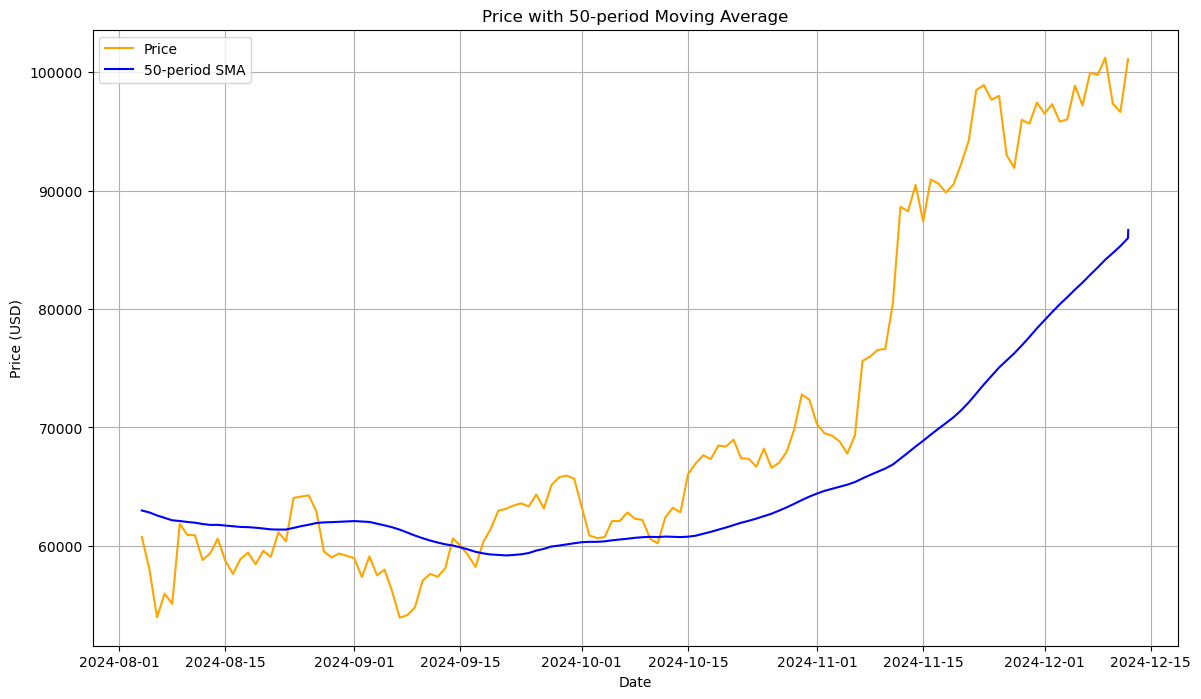

In [411]:
# Plot the price and 50-period moving average, skipping NaNs
plt.figure(figsize=(14, 8))
plt.plot(data_clean['timestamp'], data_clean['price'], label='Price', color='orange')
plt.plot(data_clean['timestamp'], data_clean['50_ma'], label='50-period SMA', color='blue')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Price with 50-period Moving Average')
plt.legend()
plt.grid(True)
plt.show()

##### Test RSI 

    timestamp         price        rsi
0  2024-06-16  66190.487489        NaN
1  2024-06-17  66615.537821        NaN
2  2024-06-18  66460.388979        NaN
3  2024-06-19  65109.314812        NaN
4  2024-06-20  64907.074608        NaN
5  2024-06-21  64844.674418        NaN
6  2024-06-22  64071.624285        NaN
7  2024-06-23  64239.903488        NaN
8  2024-06-24  63221.357384        NaN
9  2024-06-25  60363.234975        NaN
10 2024-06-26  61770.413870        NaN
11 2024-06-27  60749.896194        NaN
12 2024-06-28  61562.645326        NaN
13 2024-06-29  60317.096979  24.463310
14 2024-06-30  60864.443162  27.895190
15 2024-07-01  62734.393839  35.617032
16 2024-07-02  62819.822269  36.438498
17 2024-07-03  62042.565037  38.065835
18 2024-07-04  60244.680764  33.860737
19 2024-07-05  57189.174124  28.048575
20 2024-07-06  56739.862851  28.579171
21 2024-07-07  58230.484154  33.701916
22 2024-07-08  55880.375378  31.431718
23 2024-07-09  56665.140734  39.549967
24 2024-07-10  57988.3035

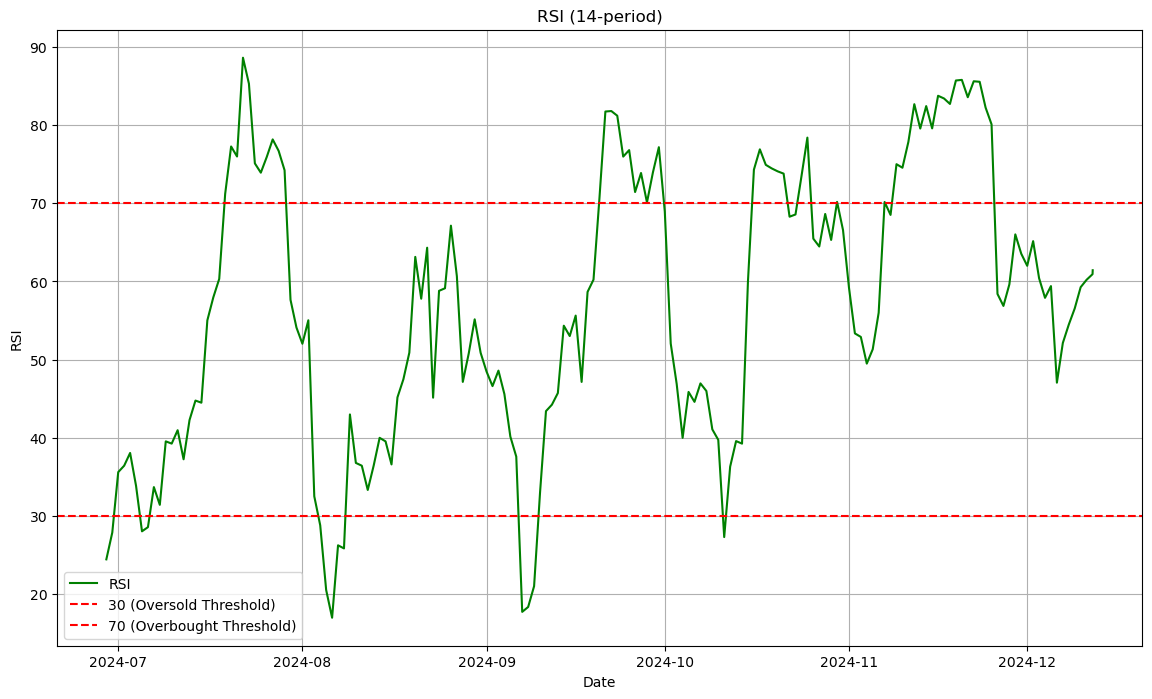

In [414]:
# Check the first few rows to ensure RSI is being calculated correctly
print(data[['timestamp', 'price', 'rsi']].head(60))  # Display the first 60 rows to check the RSI values

# Plot the RSI to verify it behaves as expected
plt.figure(figsize=(14, 8))
plt.plot(data['timestamp'], data['rsi'], label='RSI', color='green')
plt.axhline(y=30, color='red', linestyle='--', label='30 (Oversold Threshold)')
plt.axhline(y=70, color='red', linestyle='--', label='70 (Overbought Threshold)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('RSI (14-period)')
plt.legend()
plt.grid(True)
plt.show()


In [416]:
# Drop rows where the 'rsi' column has NaN values
data_clean.dropna(subset=['rsi'])

# Check the cleaned data
print(data_clean.head(60))  # Display the first 60 rows after cleaning
print(f"Number of rows in cleaned data: {len(data_clean)}")  # Check how many rows are left

     timestamp         price        rsi         50_ma         macd  \
49  2024-08-04  60738.744925  28.815672  62981.625838   301.446676   
50  2024-08-05  58006.206587  20.546258  62817.940220  -232.712008   
51  2024-08-06  53956.261842  17.000575  62564.754700  -966.030888   
52  2024-08-07  55959.841074  26.257582  62354.743742 -1372.070768   
53  2024-08-08  55099.951811  25.862670  62154.556482 -1742.045633   
54  2024-08-09  61859.031599  42.990908  62093.595622 -1480.036878   
55  2024-08-10  60912.588533  36.794071  62014.953904 -1332.455126   
56  2024-08-11  60887.708616  36.436216  61951.275591 -1203.597169   
57  2024-08-12  58804.234500  33.336155  61842.562211 -1253.340590   
58  2024-08-13  59350.074333  36.455818  61765.136550 -1234.890654   
59  2024-08-14  60601.223178  40.001241  61769.896314 -1107.453036   
60  2024-08-15  58739.193822  39.546886  61709.271913 -1142.258875   
61  2024-08-16  57624.116929  36.598463  61646.756328 -1244.743858   
62  2024-08-17  5888

### MACD

    timestamp         price         macd  macd_signal
0  2024-06-16  66190.487489          NaN          NaN
1  2024-06-17  66615.537821          NaN          NaN
2  2024-06-18  66460.388979          NaN          NaN
3  2024-06-19  65109.314812          NaN          NaN
4  2024-06-20  64907.074608          NaN          NaN
5  2024-06-21  64844.674418          NaN          NaN
6  2024-06-22  64071.624285          NaN          NaN
7  2024-06-23  64239.903488          NaN          NaN
8  2024-06-24  63221.357384          NaN          NaN
9  2024-06-25  60363.234975          NaN          NaN
10 2024-06-26  61770.413870          NaN          NaN
11 2024-06-27  60749.896194          NaN          NaN
12 2024-06-28  61562.645326          NaN          NaN
13 2024-06-29  60317.096979          NaN          NaN
14 2024-06-30  60864.443162          NaN          NaN
15 2024-07-01  62734.393839          NaN          NaN
16 2024-07-02  62819.822269          NaN          NaN
17 2024-07-03  62042.565037 

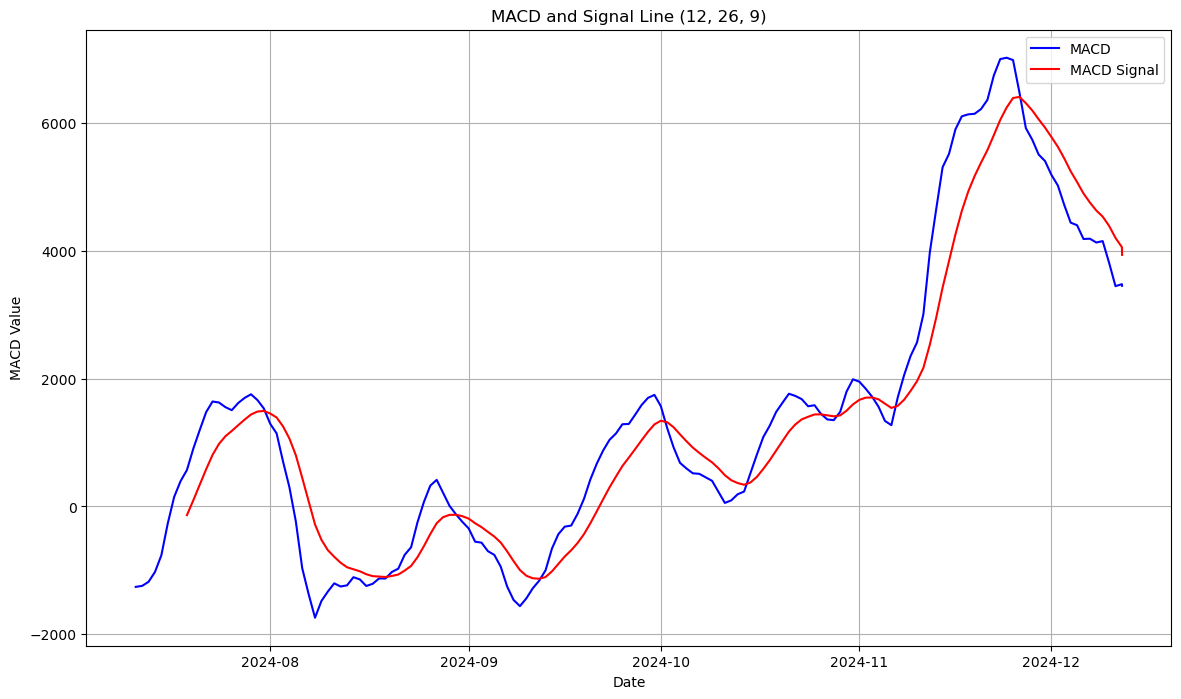

In [419]:
# Check the first few rows for MACD and Signal Line
print(data[['timestamp', 'price', 'macd', 'macd_signal']].head(60))  # Display the first 60 rows to check MACD values

# Plot the MACD and Signal line to visualize their interaction
plt.figure(figsize=(14, 8))
plt.plot(data['timestamp'], data['macd'], label='MACD', color='blue')
plt.plot(data['timestamp'], data['macd_signal'], label='MACD Signal', color='red')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.title('MACD and Signal Line (12, 26, 9)')
plt.legend()
plt.grid(True)
plt.show()


In [421]:
# Drop NaN values in 'macd' and 'macd_signal' columns
data_clean.dropna(subset=['macd', 'macd_signal'])

# Check the cleaned data
print(data_clean.head(60))  # Display the first 60 rows after cleaning
print(f"Number of rows in cleaned data: {len(data_clean)}")  # Check how many rows are left


     timestamp         price        rsi         50_ma         macd  \
49  2024-08-04  60738.744925  28.815672  62981.625838   301.446676   
50  2024-08-05  58006.206587  20.546258  62817.940220  -232.712008   
51  2024-08-06  53956.261842  17.000575  62564.754700  -966.030888   
52  2024-08-07  55959.841074  26.257582  62354.743742 -1372.070768   
53  2024-08-08  55099.951811  25.862670  62154.556482 -1742.045633   
54  2024-08-09  61859.031599  42.990908  62093.595622 -1480.036878   
55  2024-08-10  60912.588533  36.794071  62014.953904 -1332.455126   
56  2024-08-11  60887.708616  36.436216  61951.275591 -1203.597169   
57  2024-08-12  58804.234500  33.336155  61842.562211 -1253.340590   
58  2024-08-13  59350.074333  36.455818  61765.136550 -1234.890654   
59  2024-08-14  60601.223178  40.001241  61769.896314 -1107.453036   
60  2024-08-15  58739.193822  39.546886  61709.271913 -1142.258875   
61  2024-08-16  57624.116929  36.598463  61646.756328 -1244.743858   
62  2024-08-17  5888

In [423]:
# Okay we have confirmed each signal is working and determined how much we need to drop from the data
# the goal with this is to make sure we are not passing any NaN's to the ML Algorithm for backtesting

In [286]:
# Create Single Cleaned DataFrame

In [425]:
# Drop rows where any of the key columns (RSI, MACD, 50 MA) have NaN values
data_clean = data.dropna(subset=['rsi', 'macd', 'macd_signal', '50_ma'])

# Check the cleaned data
print(data_clean.head(60))  # Display the first 60 rows after cleaning
print(f"Number of rows in cleaned data: {len(data_clean)}")  # Check how many rows are left

     timestamp         price        rsi         50_ma         macd  \
49  2024-08-04  60738.744925  28.815672  62981.625838   301.446676   
50  2024-08-05  58006.206587  20.546258  62817.940220  -232.712008   
51  2024-08-06  53956.261842  17.000575  62564.754700  -966.030888   
52  2024-08-07  55959.841074  26.257582  62354.743742 -1372.070768   
53  2024-08-08  55099.951811  25.862670  62154.556482 -1742.045633   
54  2024-08-09  61859.031599  42.990908  62093.595622 -1480.036878   
55  2024-08-10  60912.588533  36.794071  62014.953904 -1332.455126   
56  2024-08-11  60887.708616  36.436216  61951.275591 -1203.597169   
57  2024-08-12  58804.234500  33.336155  61842.562211 -1253.340590   
58  2024-08-13  59350.074333  36.455818  61765.136550 -1234.890654   
59  2024-08-14  60601.223178  40.001241  61769.896314 -1107.453036   
60  2024-08-15  58739.193822  39.546886  61709.271913 -1142.258875   
61  2024-08-16  57624.116929  36.598463  61646.756328 -1244.743858   
62  2024-08-17  5888

#### Signal Logic 
##### Long Entry: Price crosses above 50-period SMA, RSI above 30, MACD crosses above signal line
##### Long Exit : Price crosses below 50-period SMA, RSI above 70, MACD crosses below signal line

In [428]:
def generate_long_signals(data_clean):
    # Ensure a copy of the DataFrame is made to avoid SettingWithCopyWarning
    data_clean = data_clean.copy()

    # Entry Signal: RSI > 30, Price > 50 MA, MACD > MACD Signal
    data_clean['entry_signal'] = (
        (data_clean['rsi'] > 30) &
        (data_clean['price'] > data_clean['50_ma']) &
        (data_clean['macd'] > data_clean['macd_signal'])
    )

    # Exit Signal: MACD < MACD Signal, RSI < 70
    data_clean['exit_signal'] = (
        (data_clean['macd'] < data_clean['macd_signal']) &
        (data_clean['rsi'] < 70)
    )

    return data_clean

In [430]:
# Apply the function
data_clean = generate_long_signals(data_clean)

# Verify the columns
print(data_clean.columns)
print(data_clean[['entry_signal', 'exit_signal']].head())


Index(['timestamp', 'price', 'rsi', '50_ma', 'macd', 'macd_signal',
       'entry_signal', 'exit_signal'],
      dtype='object')
    entry_signal  exit_signal
49         False         True
50         False         True
51         False         True
52         False         True
53         False         True


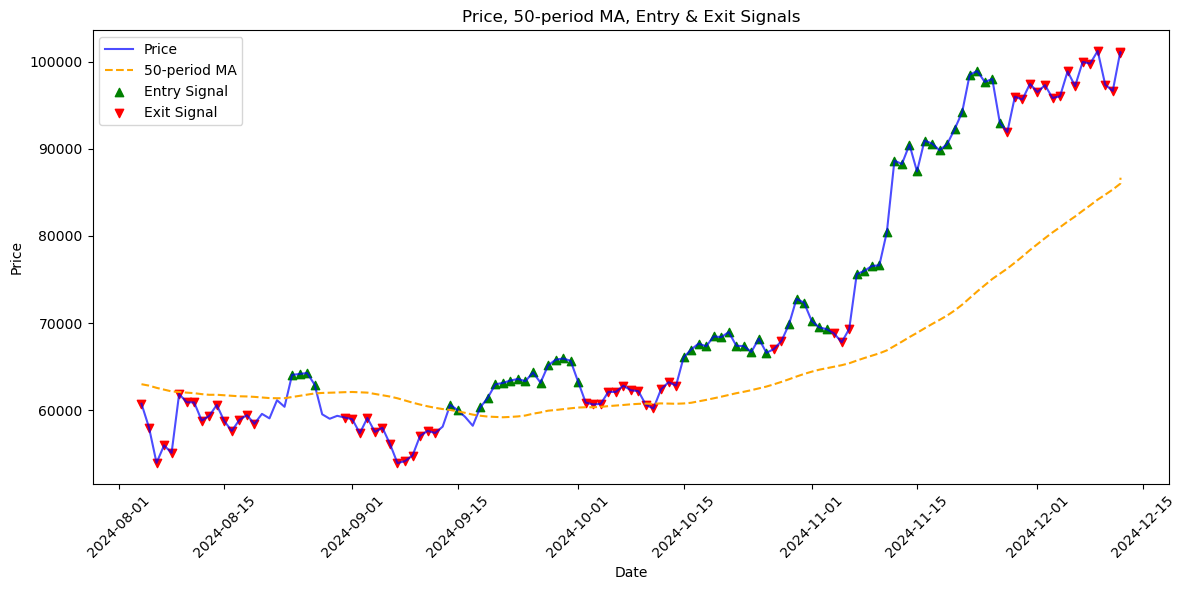

In [432]:
# Plot the price data and 50-period moving average
plt.figure(figsize=(12, 6))
plt.plot(data_clean['timestamp'], data_clean['price'], label='Price', color='blue', alpha=0.7)
plt.plot(data_clean['timestamp'], data_clean['50_ma'], label='50-period MA', color='orange', linestyle='--')

# Highlight the entry and exit signals
plt.scatter(data_clean[data_clean['entry_signal'] == True]['timestamp'], 
            data_clean[data_clean['entry_signal'] == True]['price'], 
            marker='^', color='green', label='Entry Signal', alpha=1)

plt.scatter(data_clean[data_clean['exit_signal'] == True]['timestamp'], 
            data_clean[data_clean['exit_signal'] == True]['price'], 
            marker='v', color='red', label='Exit Signal', alpha=1)

# Add labels and title
plt.title('Price, 50-period MA, Entry & Exit Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


#### This chart illustrates the current stage of signal generation based on technical indicators: RSI, 50-period moving average, and MACD. 
##### While some signals provide clear entry points, others lead to buys at local tops or miss upward movements. The strategy is still a work in progress. This is not a test of a final product, but rather an exploration in generating signals, backtesting, and integrating machine learning into my trading strategies.

##### The purpose of this project is to demonstrate the methodology and technical workflow. While the signals aren't fully optimized yet, the framework has left room for improvement and future refinement. If you have experience with trading systems or are interested in contributing to the next stages of development, there's potential to collaborate or explore the system further as it evolves.

## Model Evaluation

In [440]:
# Add a target column to classify winning and losing trades
data_clean = data_clean.copy()  # Ensure we work with a copy to avoid SettingWithCopyWarning
data_clean['target'] = (data_clean['price'].shift(-1) > data_clean['price']).astype(int)


##### train test split

In [443]:
from sklearn.model_selection import train_test_split

X = data_clean[['rsi', '50_ma', 'macd']]  # Features
y = data_clean['target']  # Target Variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

##### model selection

In [449]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)



#### LogisticRegression() is showing poor accuracy and potential bias to classification as (0)

In [452]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (y)
X = data_clean[['rsi', '50_ma', 'macd']]  # Feature columns
y = data_clean['target']  # Target column

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the class distribution
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize the classifier (Random Forest)
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train_res, y_train_res)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.5185185185185185
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.62      0.55        13
           1       0.55      0.43      0.48        14

    accuracy                           0.52        27
   macro avg       0.52      0.52      0.52        27
weighted avg       0.52      0.52      0.51        27



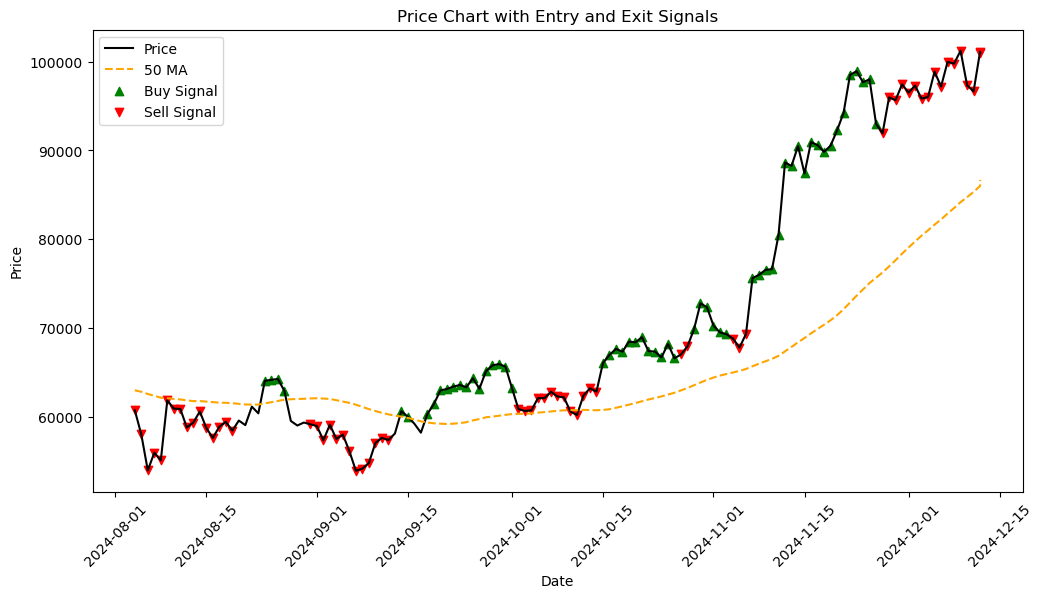

In [454]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `data_clean` has the 'entry_signal' and 'exit_signal' columns
# Create a figure
plt.figure(figsize=(12,6))

# Plot price
plt.plot(data_clean['timestamp'], data_clean['price'], label='Price', color='black')

# Plot the 50 MA for trend reference
plt.plot(data_clean['timestamp'], data_clean['50_ma'], label='50 MA', color='orange', linestyle='--')

# Highlight Entry signals (where entry_signal is True)
entry_points = np.where(data_clean['entry_signal'] == True)[0]
plt.scatter(data_clean['timestamp'].iloc[entry_points], data_clean['price'].iloc[entry_points], color='green', label='Buy Signal', marker='^')

# Highlight Exit signals (where exit_signal is True)
exit_points = np.where(data_clean['exit_signal'] == True)[0]
plt.scatter(data_clean['timestamp'].iloc[exit_points], data_clean['price'].iloc[exit_points], color='red', label='Sell Signal', marker='v')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Chart with Entry and Exit Signals')

# Show legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


#### Signals are missing something, we are not entering on the lows at the best prices and we are not entering prebreakout.
##### Adjust the signal code: Include Price Action signals to enhance the entry conditions.
- Pre-breakout signal: Price near resistance, RSI Increasing but not oversold.
- Bullish Engulfing Candle
- price near resistance, yet to breakout
- Pull-back entry signals: RSI oversold, price near support


In [457]:
# long signal with price action
def generate_long_signals_with_price_action(data):
    # Entry Signal: Look for pre-breakout (Price near previous resistance, RSI below 70 but increasing)
    data.loc[:, 'price_breakout'] = data['price'] > data['50_ma']  # Price above SMA (for trend confirmation)
    data.loc[:, 'rsi_above_30'] = data['rsi'] > 30  # RSI increasing
    data.loc[:, 'macd_above_signal'] = data['macd'] > data['macd_signal']  # MACD crossover
    data.loc[:, 'near_resistance'] = data['price'] > (data['50_ma'] * 0.99)  # Price is near resistance (e.g., 1% away)

    # Look for a Bullish Engulfing pattern
    data.loc[:, 'bullish_engulfing'] = (data['price'] > data['price'].shift(1)) & (data['price'].shift(1) < data['price'].shift(2))

    # Early breakout condition: Price near resistance but hasn't broken out yet
    data.loc[:, 'pre_breakout_signal'] = data['near_resistance'] & data['rsi_above_30'] & data['macd_above_signal'] & data['bullish_engulfing']

    # Pullback entry (RSI oversold, price near support)
    data.loc[:, 'price_pullback'] = data['price'] < data['50_ma']  # If price is below 50-period SMA
    data.loc[:, 'rsi_oversold'] = data['rsi'] < 30  # RSI < 30 for a potential pullback buy

    # Combine conditions for entry signal
    data.loc[:, 'long_entry_signal'] = (data['price_breakout'] | data['pre_breakout_signal'] | data['price_pullback']) & data['rsi_above_30'] & data['macd_above_signal']

    # Exit Signal: Price breaks below the 50-period SMA, RSI > 70, MACD < MACD Signal
    data.loc[:, 'price_below_sma'] = data['price'] < data['50_ma']
    data.loc[:, 'rsi_above_70'] = data['rsi'] > 70
    data.loc[:, 'macd_below_signal'] = data['macd'] < data['macd_signal']
    
    # Combine conditions for exit signal
    data.loc[:, 'long_exit_signal'] = data['price_below_sma'] & data['rsi_above_70'] & data['macd_below_signal']
    
    return data


In [459]:
# Example usage
data_with_signals = generate_long_signals_with_price_action(data_clean)

## Evaluate model SMA,RSI,MACD + Price Action Signals


In [462]:
#traintestsplit
from sklearn.model_selection import train_test_split

# Features (X) and target (y)
X = data_clean[['rsi', '50_ma', 'macd', 'price_breakout', 'rsi_above_30', 'macd_above_signal', 'near_resistance', 'bullish_engulfing', 'pre_breakout_signal', 'price_pullback', 'rsi_oversold']]
y = data_clean['target']  # The target variable (price goes up or down)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [464]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print the evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.5925925925925926
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.54      0.56        13
           1       0.60      0.64      0.62        14

    accuracy                           0.59        27
   macro avg       0.59      0.59      0.59        27
weighted avg       0.59      0.59      0.59        27

Confusion Matrix:
[[7 6]
 [5 9]]


In [466]:
# train(fit), model predictions, print evaluations metrics and confusion matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print the evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.5925925925925926
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.54      0.56        13
           1       0.60      0.64      0.62        14

    accuracy                           0.59        27
   macro avg       0.59      0.59      0.59        27
weighted avg       0.59      0.59      0.59        27

Confusion Matrix:
[[7 6]
 [5 9]]


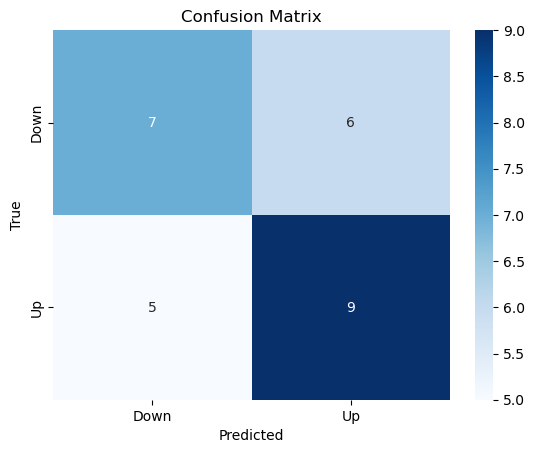

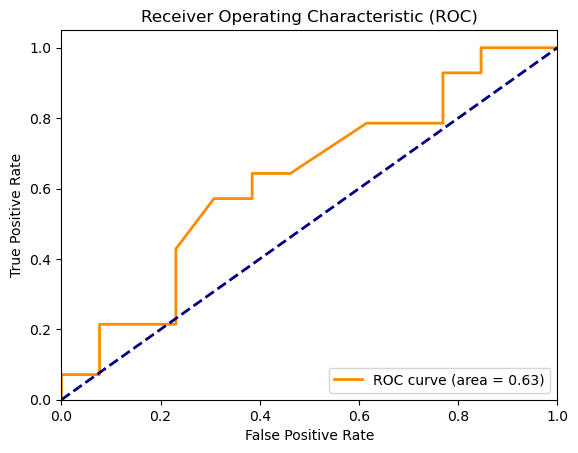

In [468]:
# visualize the confusion matrixs and ROC

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve (for binary classification)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


In [470]:
# model is missing a good amount of upmoves, a concerning amount

In [472]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Split the data into features (X) and target (y)
X = data_clean[['rsi', '50_ma', 'macd']]  # Feature columns
y = data_clean['target']  # Target column

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the class distribution (optional step based on previous results)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize the Random Forest model with class weight adjustment
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)

# Best model from grid search
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# If needed, you can also evaluate using a confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Accuracy: 0.5185185185185185
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.62      0.55        13
           1       0.55      0.43      0.48        14

    accuracy                           0.52        27
   macro avg       0.52      0.52      0.52        27
weighted avg       0.52      0.52      0.51        27

Confusion Matrix:
[[8 5]
 [8 6]]


In [473]:
# try a different model to see if we can get better accuracy.

In [474]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Split the data into features (X) and target (y)
X = data_clean[['rsi', '50_ma', 'macd']]  # Feature columns
y = data_clean['target']  # Target column

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the class distribution
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize XGBoost model
xgb_model = XGBClassifier(scale_pos_weight=1, random_state=42)

# Train the model
xgb_model.fit(X_train_res, y_train_res)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# try logistic regression again

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Predict
y_pred_logreg = logreg.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Split data
X = data_clean[['rsi', '50_ma', 'macd']]  # Features
y = data_clean['target']  # Target

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Train model
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [479]:
# try scaling features

In [481]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Scaling featurestwi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train with cross-validation using Random Forest
rf = RandomForestClassifier(random_state=42)
cross_val_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='accuracy')

print("Cross-validation accuracy scores:", cross_val_scores)
print("Average cross-validation accuracy:", cross_val_scores.mean())


Cross-validation accuracy scores: [0.55555556 0.59259259 0.65384615 0.42307692 0.34615385]
Average cross-validation accuracy: 0.5142450142450142


### Feature Engineering
- we have hit an accuracy of 44%, which is okay for trading.
- if of the 100% of the trades we take, 44% are profitable, and 56% are losses
- if we define exit signals that cut the 56% of trades that lose, we can mitigate losses.
- cutting the losses and running the profits at a 44% win rate, we get a positive yearly return.

#### proposed solutions
- add rolling mean/median for RSI,MACD, and other indicators
    - this smooths price to capture longer-term trend
- add standard deviations for RSI,MACD, and other indicators
    - to capture price volatility and mean reversion plays
- Lag Price & other features
    - use % change in daily price to capture momentum swings
    - see if the machine can get anything from lagging other featuers for RSI, MACD, and SMA
- Combine Features
    - capture relationships between variables
- RSI Zones
    - categorize the RSI into zones for oversold, neutral, and overbought
    - this could give the model better insights
- Moving Average Crosses
    - Moving average crossovers signal price movement, just need to find the right periods
- Price Volatility
    - Measure volatitily over different time periods
- Trend Indicators
    - Average directional index (ADX) to guage trend strength
    - I don't have ADX so i'm gonna create one myself
    - (long period SMA - short period SMA)

### **** Feature Notes: Incorporate additional candlestickpatterns and candlestick sequences

In [486]:
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [488]:
def calculate_sma(prices, window=50):
    return prices.rolling(window=window).mean()

In [490]:
def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    short_ema = prices.ewm(span=short_window, adjust=False).mean()
    long_ema = prices.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal


In [492]:
def generate_features(data):
    data['rsi'] = calculate_rsi(data['price'])
    data['50_ma'] = calculate_sma(data['price'])
    data['macd'], data['macd_signal'] = calculate_macd(data['price'])
    return data


In [494]:
data_features = generate_features(data)


#### traintestsplit the new model
#### including SMOTE for class balancing, as we know that improved our accuracy by 7% before.

In [497]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Define your features and target
X = data_clean[['rsi', '50_ma', 'macd', 'price_breakout', 'rsi_above_30', 'macd_above_signal', 'price_pullback', 'rsi_oversold', 'pre_breakout_signal']]  # Add all features here
y = data_clean['target']  # Target variable (price will go up or down)

# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the class distribution in the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


#### Scale the updated features and fit the model


In [500]:
# Scale the features
scaler = StandardScaler()

# Fit and transform the training data, and transform the test data
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train_res)

RandomForestClassifier(random_state=42)

#### Make Prediction
- print: accuracy, classifiactions report, confusion matrix

In [503]:
# Make prediction
y_pred = model.predict(X_test_scaled)

In [505]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.5185185185185185
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.62      0.55        13
           1       0.55      0.43      0.48        14

    accuracy                           0.52        27
   macro avg       0.52      0.52      0.52        27
weighted avg       0.52      0.52      0.51        27

Confusion Matrix:
[[8 5]
 [8 6]]


In [507]:
# Scale the features using StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train_res)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Train the model on the scaled data
model.fit(X_train_scaled, y_train_res)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.5185185185185185
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.62      0.55        13
           1       0.55      0.43      0.48        14

    accuracy                           0.52        27
   macro avg       0.52      0.52      0.52        27
weighted avg       0.52      0.52      0.51        27

Confusion Matrix:
[[8 5]
 [8 6]]


#### That didn't do anything... onto the next thing
- which i guess would be to adjust the balance again
- this should ideally improve the recall for class 1 (entry)
- set class weight to "balanced"

In [510]:
# class weight adjustment in the random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Define your features and target
X = data_clean[['rsi', '50_ma', 'macd', 'price_breakout', 'rsi_above_30', 'macd_above_signal', 'price_pullback', 'rsi_oversold', 'pre_breakout_signal']]  # Add all features here
y = data_clean['target']  # Target variable (price will go up or down)

# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the class distribution in the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize the RandomForestClassifier with class_weight='balanced'
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
rf_model.fit(X_train_res, y_train_res)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.5185185185185185
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.62      0.55        13
           1       0.55      0.43      0.48        14

    accuracy                           0.52        27
   macro avg       0.52      0.52      0.52        27
weighted avg       0.52      0.52      0.51        27

Confusion Matrix:
[[8 5]
 [8 6]]


## Closing Notes
#### Alrighty, we've gotta move to a new notebook now this is getting clutters
- We want better recall for profitable trades (class 1) without too much overfitting. Improving class recall while maintaining accuracy, even if it means slightly sacrificing precision, will give us the most valuable information for a trading system.
- Let’s clean up the process and make targeted changes:
    - Work on improving class weights.
    - Keep fine-tuning feature engineering and try other models once we’ve adjusted for better performance.

## The Next Steps
- Create modular testing template to use as a base for new experiments/test
    - For each test set
      - load data
      - implement any desired feature adjustments
      - fine-tune classweights / SMOTE settings
      - Run models on fresh data